In [ ]:
!pip install transformers
!pip install pytorch-crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.5 MB/s eta 0:00:00


In [ ]:
import joblib
import torch
import torch.nn as nn
import transformers
from torchcrf import CRF
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import model_selection

from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging,AdamW




In [ ]:
class config:
    MAX_LEN = 165
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    BASE_MODEL_PATH = "vinai/phobert-base-v2"
    MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/test_model/best_model_crf2.pth"
    TRAINING_FILE = "/content/drive/MyDrive/Colab Notebooks/vietnam ner/train_2016_final.csv"
    TESTING_FILE = "/content/drive/MyDrive/Colab Notebooks/vietnam ner/test_2016_final.csv"
    TOKENIZER = transformers.AutoTokenizer.from_pretrained(BASE_MODEL_PATH, do_lower_case=True)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv(config.TRAINING_FILE,encoding='utf-16')
train_data.head()

,Sentences,Word,POS1,TAG
0,0,Đó,P,O
1,0,là,V,O
2,0,con,Nc,O
3,0,đường,N,O
4,0,biển,N,O


In [ ]:
test_data = pd.read_csv(config.TESTING_FILE, encoding='utf-16')
test_data.head()

,Sentences,Word,POS1,TAG
0,0,Chị,Nc,O
1,0,Minh,Np,B-PER
2,0,ôm,V,O
3,0,đứa,Nc,O
4,0,con_gái,N,O


In [ ]:
count = 0
count_list = []
previous_sentence = None

for sentence in test_data['Sentences']:
    if sentence != previous_sentence:
        count_list.append(count)
        count = 1
        previous_sentence = sentence
    else:
        count += 1


count_list.append(count)


print(max(count_list))

value =5
indices = [index for index, element in enumerate(count_list) if element == value]
print("Indices:", indices)

148
Indices: [153, 358, 361, 426, 434, 460, 471, 474, 485, 637, 646, 658, 989, 1129, 1141, 1218, 1236, 1434, 1614, 1625, 1628, 1785, 1864, 1904, 1923, 1949, 2016, 2118, 2180, 2277, 2322, 2478, 2494, 2537, 2543]


In [ ]:
unique_values = train_data['TAG'].unique()
print(unique_values)


['O' 'B-LOC' 'B-ORG' 'I-LOC' 'B-PER' 'I-PER' 'I-ORG' 'B-MISC' 'I-MISC']


In [ ]:
class EntityDataset:
    def __init__(self, texts, pos, tags):
        self.texts = texts
        self.pos = pos
        self.tags = tags
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        pos = self.pos[item]
        tags = self.tags[item]

        ids = []
        target_pos = []
        target_tag =[]
        mask=[]
        token_type_ids=[]


        inputs = config.TOKENIZER.encode(
                text,
                add_special_tokens=False
            )
        input_len = len(inputs)
        padding_len =config.MAX_LEN - input_len
        ids.extend(inputs + [0]*padding_len )
        target_pos.extend(pos+ [2]*padding_len)
        target_tag.extend(tags + [8]*padding_len)

        mask.extend([1] * input_len + [0]*padding_len)
        token_type_ids.extend([0]*config.MAX_LEN)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_pos": torch.tensor(target_pos, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }

In [ ]:
def process_data(data_path):
    df = pd.read_csv(data_path,encoding='utf-16')

    df.dropna(inplace=True)

    enc_tag = preprocessing.LabelEncoder()
    enc_pos = preprocessing.LabelEncoder()
    df.loc[:, "TAG"] = enc_tag.fit_transform(df["TAG"])
    df.loc[:, "POS1"] = enc_pos.fit_transform(df["POS1"])

    sentences = df.groupby("Sentences")["Word"].apply(list).values
    tag = df.groupby("Sentences")["TAG"].apply(list).values
    pos= df.groupby("Sentences")["POS1"].apply(list).values
    df.loc[:, "OriginalLabel"] = enc_tag.inverse_transform(df["TAG"])
    df.loc[:, "OriginalPOS"] = enc_pos.inverse_transform(df["POS1"])


    label_mapping = df[["TAG", "OriginalLabel"]].drop_duplicates().sort_values("TAG")
    pos_mapping = df[["POS1", "OriginalPOS"]].drop_duplicates().sort_values("POS1")

    print("Label Mapping:")
    for _, row in label_mapping.iterrows():
        print(f"{row['TAG']}: {row['OriginalLabel']}")
    print("POS Mapping:")
    for _, row in pos_mapping.iterrows():

        print(f"{row['POS1']}: {row['OriginalPOS']}")


    return sentences, tag, enc_tag,pos,enc_pos

In [ ]:
train_sentences, train_tag, enc_tag_train,pos_tag, enc_pos = process_data(config.TRAINING_FILE)

<ipython-input-8-9733d328cf64>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "TAG"] = enc_tag.fit_transform(df["TAG"])
<ipython-input-8-9733d328cf64>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS1"] = enc_pos.fit_transform(df["POS1"])


Label Mapping:
0: B-LOC
1: B-MISC
2: B-ORG
3: B-PER
4: I-LOC
5: I-MISC
6: I-ORG
7: I-PER
8: O
POS Mapping:
0: A
1: C
2: CH
3: E
4: FW
5: I
6: L
7: M
8: N
9: Nc
10: Np
11: Nu
12: Ny
13: P
14: R
15: T
16: V
17: Vy
18: X
19: Z


In [ ]:
meta_data = {
    "enc_pos": enc_pos,
    "enc_tag": enc_tag_train
}

joblib.dump(meta_data, "/content/drive/MyDrive/Colab Notebooks/vietnam ner/encoded.bin")

['/content/drive/MyDrive/Colab Notebooks/ner vietnam/encoded.bin']

In [ ]:
train_sentences

array([list(['Đó', 'là', 'con', 'đường', 'biển', 'ngắn', 'nhất', 'để', 'đi', 'từ', 'Ấn Độ Dương', 'sang', 'Thái Bình Dương', ',', 'chiếm', 'đến', 'lượng', 'hàng hoá', 'lưu thông', 'đường biển', 'của', 'thế giới', ',', 'đó', 'là', 'hải trình', 'lớn', 'nhất', 'từ', 'tây', 'sang', 'đông', 'với', '50.000', 'lượt', 'tàu bè', 'qua lại', 'mỗi', 'năm', '...']),
       list(['Một', 'chuyến', 'hải trình', 'xuyên', 'ba', 'nước', 'Malaysia', ',', 'Singapore', ',', 'Indonesia', 'vừa', 'được', 'phóng viên', 'Tuổi Trẻ', 'thực hiện', ',', 'để', 'cảm nhận', 'điều', 'mà', 'các', 'thuỷ thủ', 'tàu', 'viễn dương', 'đã', 'cảm nhận', 'mỗi', 'khi', 'nghe', 'nhắc', 'tới', ':', 'hải tặc', 'eo biển', 'Malacca', '!', '...']),
       list(['Từ', 'bức', 'điện', 'của', 'IMB', '...']), ...,
       list(['Cậu', 'bé', 'sôi nổi', 'nhiệt tình', 'ấy', 'không', 'hiểu', 'có', 'chịu', 'nổi', 'những', 'đòn', 'tra tấn', 'của', 'quân thù', 'hay', 'không', '.']),
       list(['Thương', 'Đường', 'vô tận', '.']),
       list(['Lá'

In [ ]:
test_sentences, test_tag, enc_tag_test,pos_tag_test, enc_pos_test = process_data(config.TESTING_FILE)

<ipython-input-8-9733d328cf64>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "TAG"] = enc_tag.fit_transform(df["TAG"])
<ipython-input-8-9733d328cf64>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS1"] = enc_pos.fit_transform(df["POS1"])


Label Mapping:
0: B-LOC
1: B-MISC
2: B-ORG
3: B-PER
4: I-LOC
5: I-MISC
6: I-ORG
7: I-PER
8: O
POS Mapping:
0: A
1: C
2: CH
3: E
4: FW
5: I
6: L
7: M
8: N
9: Nc
10: Np
11: Nu
12: Ny
13: P
14: R
15: T
16: V
17: Vy
18: X
19: Z


In [ ]:
train_dataset = EntityDataset(texts=train_sentences, pos=pos_tag, tags=train_tag)

In [ ]:
train_dataset[0]

{'ids': tensor([  669,     8,    73,   109,   262,  1131,    67,    24,    57,    39,
         10148,   295,  2832,     4,   724,    30,   525,  1075,  2227, 12033,
             7,   198,     4,    37,     8, 31425,   103,    67,    39,  2615,
           295,   553,    15,  3976,  1030, 30254,  4457,   205,    29,   135,
           242,   550, 31425,  2121,   346,    58,  1396,     4,  1462,     4,
          1550,   164,    11,  1259, 12064,   112,     4,    24,  2601,   184,
            64,     9,  5840,   356,     3,    14,  2601,   205,    26,   523,
          1630,    75,    27, 29182, 10820, 31357,   381,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [ ]:
test_dataset = EntityDataset(texts=test_sentences, pos=pos_tag_test, tags=test_tag)

In [ ]:
for item in train_dataset:
    id = item['ids'].tolist()
    attention_mask = item['mask'].tolist()
    token_type_id = item['token_type_ids'].tolist()
    targets = item['target_tag'].tolist()
    pos = item['target_pos'].tolist()


    print("input id:", id)
    print("attention mask:", attention_mask)
    print("token type id:", token_type_id)
    print("pos:", pos)
    print("targets:", targets)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.VALID_BATCH_SIZE, num_workers=1)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def train_fn(data_loader, model, optimizer,optimizer1, device, scheduler):
    model.train()
    pos_losses = []
    ner_losses = []

    predicted=[]
    real=[]
    predicted_pos=[]
    real_pos=[]



    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        optimizer1.zero_grad()
        output_tag, output_pos, loss_tag,loss = model(**data)
        # pro.append(p)




        loss.backward(retain_graph=True)
        loss_tag.backward(retain_graph=True)

        for sublist_a, sublist_b in zip(output_tag, data["target_tag"]):
          n = len(sublist_a)
          first_n_values = sublist_b[:n]

          real.append(first_n_values)
          predicted.append(sublist_a)

        for sublist_a, sublist_b in zip(output_pos, data["target_pos"]):
          n = len(sublist_a)
          first_n_values = sublist_b[:n]

          real_pos.append(first_n_values)
          predicted_pos.append(sublist_a)


        optimizer.step()
        optimizer1.step()
        scheduler.step()

        pos_losses.append(loss.item())
        ner_losses.append(loss_tag.item())

    avg_pos_loss = sum(pos_losses) / len(pos_losses)
    avg_ner_loss = sum(ner_losses) / len(ner_losses)

    y_true_tag = torch.tensor([label for sublist in real for label in sublist]).cpu()
    del real
    y_pred_tag = torch.tensor([label for sublist in predicted for label in sublist]).cpu()
    del predicted
    f1_tag = f1_score(y_true_tag, y_pred_tag, average='micro')

    y_true_pos = torch.tensor([label for sublist in real_pos for label in sublist]).cpu()
    del real_pos
    y_pred_pos = torch.tensor([label for sublist in predicted_pos for label in sublist]).cpu()
    del predicted_pos
    f1_pos = f1_score(y_true_pos, y_pred_pos, average='micro')


    return avg_pos_loss, avg_ner_loss,f1_pos,f1_tag

def eval_fn(data_loader, model, device):
    model.eval()
    pos_losses = []
    ner_losses = []

    predicted=[]
    real=[]
    predicted_pos=[]
    real_pos=[]



    with torch.no_grad():
      for data in tqdm(data_loader, total=len(data_loader)):
          for k, v in data.items():
              data[k] = v.to(device)

          output_tag, output_pos, loss_tag,loss = model(**data)

          pos_losses.append(loss.item())
          ner_losses.append(loss_tag.item())
          for sublist_a, sublist_b in zip(output_tag, data["target_tag"]):
            n = len(sublist_a)
            first_n_values = sublist_b[:n]

            real.append(first_n_values)
            predicted.append(sublist_a)

          for sublist_a, sublist_b in zip(output_pos, data["target_pos"]):
            n = len(sublist_a)
            first_n_values = sublist_b[:n]

            real_pos.append(first_n_values)
            predicted_pos.append(sublist_a)

      avg_pos_loss = sum(pos_losses) / len(pos_losses)
      avg_ner_loss = sum(ner_losses) / len(ner_losses)

      y_true_tag = torch.tensor([label for sublist in real for label in sublist]).cpu()
      del real
      y_pred_tag = torch.tensor([label for sublist in predicted for label in sublist]).cpu()
      del predicted
      f1_tag = f1_score(y_true_tag, y_pred_tag, average='micro')

      y_true_pos = torch.tensor([label for sublist in real_pos for label in sublist]).cpu()
      del real_pos
      y_pred_pos = torch.tensor([label for sublist in predicted_pos for label in sublist]).cpu()
      del predicted_pos
      f1_pos = f1_score(y_true_pos, y_pred_pos, average='micro')


    return avg_pos_loss, avg_ner_loss,f1_pos,f1_tag


In [ ]:
import torch.nn.functional as F
log_soft = F.log_softmax

In [ ]:
class EntityModel(nn.Module):
    def __init__(self, num_tag, num_pos):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.num_pos = num_pos
        self.phobert = transformers.AutoModel.from_pretrained(config.BASE_MODEL_PATH,return_dict=False)
        # for param in self.phobert.parameters():
        #     param.requires_grad = False
        self.bert_drop_1 = nn.Dropout(0.3)
        self.bert_drop_2 = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)
        self.out_pos = nn.Linear(768, self.num_pos)
        self.crf = CRF(num_tag, batch_first = True)
        self.crf_pos = CRF(num_pos, batch_first = True)
    def forward(
        self,
        ids,
        mask,
        token_type_ids,
        target_pos,
        target_tag
    ):
        o1, _ = self.phobert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )

        bo_tag = self.bert_drop_1(o1)
        bo_pos = self.bert_drop_2(o1)

        tag = self.out_tag(bo_tag)
        pos = self.out_pos(bo_pos)



        if target_tag is not None:
            loss_tag = -self.crf(log_soft(tag, 2), target_tag, mask=mask.type(torch.uint8), reduction='mean')
            prediction = self.crf.decode(tag, mask=mask.type(torch.uint8))


        else:
            prediction = self.crf.decode(tag, mask=mask.type(torch.uint8))
            # return prediction

        if target_pos is not None:
            loss_pos = -self.crf_pos(log_soft(pos, 2), target_pos, mask=mask.type(torch.uint8), reduction='mean')
            pos_prediction = self.crf_pos.decode(pos, mask=mask.type(torch.uint8))


        else:
            pos_prediction = self.crf_pos.decode(pos, mask=mask.type(torch.uint8))


        return prediction, pos_prediction,loss_tag,loss_pos

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
num_tag = len(list(enc_tag_train.classes_))
num_pos = len(list(enc_pos.classes_))

In [ ]:
num_tag

9

In [ ]:
num_pos

20

In [ ]:
model = EntityModel(num_tag=9, num_pos=20)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EntityModel(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [ ]:
param_optimizer = list(model.named_parameters())
# no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# optimizer_parameters = [
#     {
#         "params": [
#             p for n, p in param_optimizer if not any(
#                 nd in n for nd in no_decay
#             )
#         ],
#         "weight_decay": 0.01,
#     },
#     {
#         "params": [
#             p for n, p in param_optimizer if any(
#                 nd in n for nd in no_decay
#             )
#         ],
#         "weight_decay": 0.01,
#     },
# ]


In [ ]:
param_optimizer

[('phobert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0367, -0.0131, -0.0562,  ...,  0.0061,  0.0037, -0.0051],
          [ 0.0359,  0.0122, -0.0007,  ...,  0.0014, -0.0053,  0.0222],
          [ 0.0252,  0.0068, -0.0004,  ..., -0.0183,  0.0312,  0.0361],
          ...,
          [ 0.0403, -0.0513, -0.0025,  ..., -0.0355, -0.0694,  0.0204],
          [ 0.0535,  0.0157, -0.0067,  ...,  0.0222, -0.0061,  0.0074],
          [ 0.0360,  0.0015, -0.0145,  ...,  0.0104, -0.0065,  0.0368]],
         device='cuda:0')),
 ('phobert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0075, -0.0013, -0.0034,  ..., -0.0011,  0.0038,  0.0054],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0062,  0.0027, -0.0442,  ...,  0.0060, -0.0080,  0.0762],
          ...,
          [ 0.0037, -0.0170, -0.0121,  ..., -0.0130,  0.0182,  0.0365],
          [-0.0017, -0.0339, -0.0187,  ..., -0.0186, -0.0128,  0.0281],
   

In [ ]:
optimizer_parameters

[{'params': [Parameter containing:
   tensor([[ 0.0367, -0.0131, -0.0562,  ...,  0.0061,  0.0037, -0.0051],
           [ 0.0359,  0.0122, -0.0007,  ...,  0.0014, -0.0053,  0.0222],
           [ 0.0252,  0.0068, -0.0004,  ..., -0.0183,  0.0312,  0.0361],
           ...,
           [ 0.0403, -0.0513, -0.0025,  ..., -0.0355, -0.0694,  0.0204],
           [ 0.0535,  0.0157, -0.0067,  ...,  0.0222, -0.0061,  0.0074],
           [ 0.0360,  0.0015, -0.0145,  ...,  0.0104, -0.0065,  0.0368]],
          device='cuda:0'),
   Parameter containing:
   tensor([[ 0.0075, -0.0013, -0.0034,  ..., -0.0011,  0.0038,  0.0054],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0062,  0.0027, -0.0442,  ...,  0.0060, -0.0080,  0.0762],
           ...,
           [ 0.0037, -0.0170, -0.0121,  ..., -0.0130,  0.0182,  0.0365],
           [-0.0017, -0.0339, -0.0187,  ..., -0.0186, -0.0128,  0.0281],
           [-0.0218,  0.0849, -0.0456,  ..., -0.1043,  0.1484,  0.0963]],
  

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

35159

In [ ]:
del model

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# no_decay = ['bias', 'gamma', 'beta','LayerNorm.weight','LayerNorm.bias']
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.01,
    },
]

In [ ]:
optimizer_parameters

[{'params': [Parameter containing:
   tensor([[ 0.0367, -0.0131, -0.0562,  ...,  0.0061,  0.0037, -0.0051],
           [ 0.0359,  0.0122, -0.0007,  ...,  0.0014, -0.0053,  0.0222],
           [ 0.0252,  0.0068, -0.0004,  ..., -0.0183,  0.0312,  0.0361],
           ...,
           [ 0.0403, -0.0513, -0.0025,  ..., -0.0355, -0.0694,  0.0204],
           [ 0.0535,  0.0157, -0.0067,  ...,  0.0222, -0.0061,  0.0074],
           [ 0.0360,  0.0015, -0.0145,  ...,  0.0104, -0.0065,  0.0368]],
          device='cuda:0'),
   Parameter containing:
   tensor([[ 0.0075, -0.0013, -0.0034,  ..., -0.0011,  0.0038,  0.0054],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0062,  0.0027, -0.0442,  ...,  0.0060, -0.0080,  0.0762],
           ...,
           [ 0.0037, -0.0170, -0.0121,  ..., -0.0130,  0.0182,  0.0365],
           [-0.0017, -0.0339, -0.0187,  ..., -0.0186, -0.0128,  0.0281],
           [-0.0218,  0.0849, -0.0456,  ..., -0.1043,  0.1484,  0.0963]],
  

In [ ]:
param_optimizer = list(model.named_parameters())
# no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# no_decay = ['bias', 'gamma', 'beta','LayerNorm.weight','LayerNorm.bias']
no_decay = ['bias', 'gamma', 'beta',"LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.001,
    }

]

num_train_steps = int(
    len(train_sentences) / config.TRAIN_BATCH_SIZE * 10
)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
optimizer1 = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

best_loss = np.inf
# best_acc = 0.0
for epoch in range(10):
    train_pos_losses, train_ner_losses,f1_pos_train,f1_tag_train = train_fn(
        train_data_loader,
        model,
        optimizer,
        optimizer1,
        device,
        scheduler
    )

    test_pos_losses, test_ner_losses,f1_pos_test,f1_tag_test = eval_fn(
        test_data_loader,
        model,
        device
    )

    print(f"Train POS Loss = {train_pos_losses:.4f}")
    print(f"Train NER Loss = {train_ner_losses:.4f}")
    print(f"Valid POS Loss = {test_pos_losses:.4f}")
    print(f"Valid NER Loss = {test_ner_losses:.4f}")

    print(f"Train POS F1 = {f1_pos_train:.4f}")
    print(f"Train NER f1 = {f1_tag_train:.4f}")
    print(f"Valid POS f1 = {f1_pos_test:.4f}")
    print(f"Valid NER f1 = {f1_tag_test:.4f}")


    test=test_pos_losses + test_ner_losses
    if test < best_loss:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/test_model/best_model_crf2.pth')
        print("Save model.")
        best_loss = test
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/test_model/best_model_crf3.pth')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 322/322 [01:06<00:00,  4.87it/s]


Train POS Loss = 20.5486
Train NER Loss = 6.0371
Valid POS Loss = 9.6123
Valid NER Loss = 2.7520
Train POS F1 = 0.7980
Train NER f1 = 0.9595
Valid POS f1 = 0.9097
Valid NER f1 = 0.9798
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:06<00:00,  4.83it/s]


Train POS Loss = 7.7432
Train NER Loss = 2.0250
Valid POS Loss = 8.1558
Valid NER Loss = 1.8256
Train POS F1 = 0.9197
Train NER f1 = 0.9845
Valid POS f1 = 0.9125
Valid NER f1 = 0.9860
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:06<00:00,  4.86it/s]


Train POS Loss = 6.1359
Train NER Loss = 1.2256
Valid POS Loss = 7.4473
Valid NER Loss = 1.3434
Train POS F1 = 0.9299
Train NER f1 = 0.9908
Valid POS f1 = 0.9171
Valid NER f1 = 0.9888
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:06<00:00,  4.88it/s]


Train POS Loss = 4.9856
Train NER Loss = 0.8514
Valid POS Loss = 6.9335
Valid NER Loss = 1.1312
Train POS F1 = 0.9410
Train NER f1 = 0.9933
Valid POS f1 = 0.9216
Valid NER f1 = 0.9897
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:05<00:00,  4.93it/s]


Train POS Loss = 4.2021
Train NER Loss = 0.6495
Valid POS Loss = 6.7864
Valid NER Loss = 1.0990
Train POS F1 = 0.9498
Train NER f1 = 0.9948
Valid POS f1 = 0.9255
Valid NER f1 = 0.9897
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:05<00:00,  4.94it/s]


Train POS Loss = 3.6078
Train NER Loss = 0.5078
Valid POS Loss = 6.7620
Valid NER Loss = 1.0577
Train POS F1 = 0.9565
Train NER f1 = 0.9960
Valid POS f1 = 0.9272
Valid NER f1 = 0.9903
Save model.


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:05<00:00,  4.94it/s]


Train POS Loss = 3.1096
Train NER Loss = 0.4068
Valid POS Loss = 7.0246
Valid NER Loss = 1.0999
Train POS F1 = 0.9627
Train NER f1 = 0.9968
Valid POS f1 = 0.9264
Valid NER f1 = 0.9893


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:04<00:00,  4.95it/s]


Train POS Loss = 2.7315
Train NER Loss = 0.3595
Valid POS Loss = 6.9843
Valid NER Loss = 1.0861
Train POS F1 = 0.9674
Train NER f1 = 0.9972
Valid POS f1 = 0.9272
Valid NER f1 = 0.9895


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:05<00:00,  4.92it/s]


Train POS Loss = 2.4521
Train NER Loss = 0.3136
Valid POS Loss = 6.9556
Valid NER Loss = 1.0761
Train POS F1 = 0.9713
Train NER f1 = 0.9976
Valid POS f1 = 0.9284
Valid NER f1 = 0.9895


  0%|          | 0/425 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 322/322 [01:04<00:00,  4.99it/s]


Train POS Loss = 2.2755
Train NER Loss = 0.2913
Valid POS Loss = 6.8937
Valid NER Loss = 1.0782
Train POS F1 = 0.9732
Train NER f1 = 0.9978
Valid POS f1 = 0.9294
Valid NER f1 = 0.9895


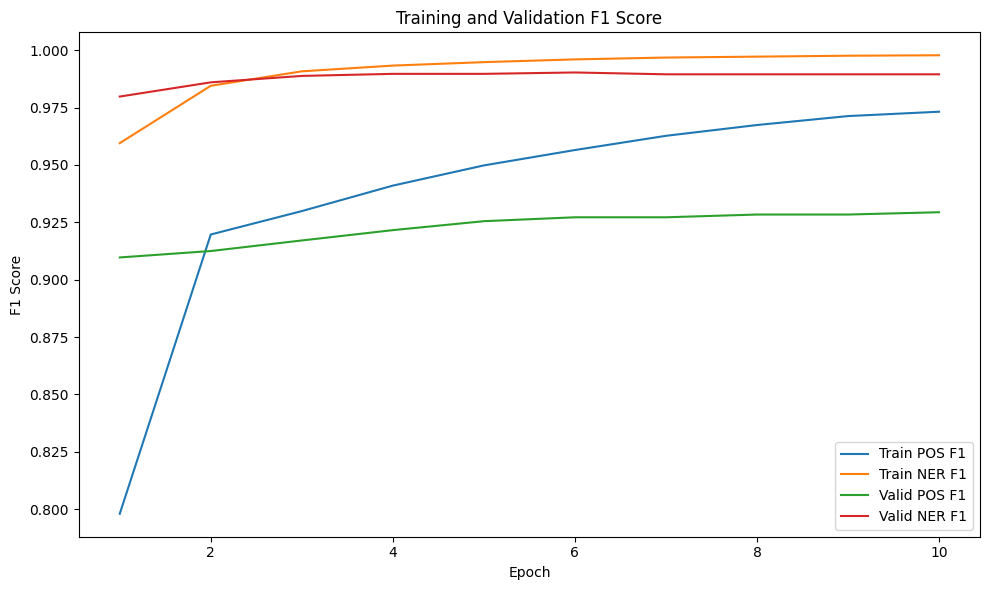

In [ ]:
import matplotlib.pyplot as plt

# Data for each epoch
epochs = [1, 2, 3, 4, 5, 6, 7, 8,9,10]
train_pos_loss = [20.5486, 7.7432, 6.1359, 4.9856, 4.2021, 3.6078, 3.1096, 2.7315,2.4521,2.2755]
train_ner_loss = [6.0371, 2.0250, 1.2256, 0.8514, 0.6495, 0.5078, 0.4068, 0.3595,0.3136,0.2913]
valid_pos_loss = [9.6123, 8.1558, 7.4473, 6.9335, 6.7864, 6.7620, 7.0246, 6.9843,6.9556,6.8937]
valid_ner_loss = [2.7520, 1.8256, 1.3434, 1.1312, 1.0990, 1.0577, 1.0999, 1.0861,1.0761,1.0782]
train_pos_f1 = [0.7980, 0.9197, 0.9299, 0.9410, 0.9498, 0.9565, 0.9627, 0.9674,0.9713,0.9732]
train_ner_f1 = [0.9595, 0.9845, 0.9908, 0.9933, 0.9948, 0.9960, 0.9968, 0.9972,0.9976,0.9978]
valid_pos_f1 = [0.9097, 0.9125, 0.9171, 0.9216, 0.9255, 0.9272, 0.9272, 0.9284,0.9284,0.9294]
valid_ner_f1 = [0.9798, 0.9860, 0.9888, 0.9897, 0.9897, 0.9903, 0.9895, 0.9895,0.9895,0.9895]

plt.figure(figsize=(10, 6))

# F1 score plots
plt.plot(epochs, train_pos_f1, label='Train POS F1')
plt.plot(epochs, train_ner_f1, label='Train NER F1')
plt.plot(epochs, valid_pos_f1, label='Valid POS F1')
plt.plot(epochs, valid_ner_f1, label='Valid NER F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/test_model/best_model_crf2.pth')

In [ ]:
meta_data = joblib.load("/content/drive/MyDrive/Colab Notebooks/ner vietnam/encoded.bin")
enc_pos = meta_data["enc_pos"]
enc_tag = meta_data["enc_tag"]

num_pos = len(list(enc_pos.classes_))
num_tag = len(list(enc_tag.classes_))
model = EntityModel(num_tag=9, num_pos=20)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ner vietnam/best_model.pth', map_location=torch.device('cpu')))
model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EntityModel(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [ ]:
sentence = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."
a=modellllll.annotate_text(sentence)

word_list = []
for value_list in a.values():
    for value_dict in value_list:
        word = value_dict['wordForm']
        words_without_underscore = ' '.join(word.split('_'))
        word_list.append(words_without_underscore)

print(word_list)
tokenized_sentence = config.TOKENIZER.encode(word_list)
test_dataset = EntityDataset(
    texts=[sentence],
    pos=[[0] * len(sentence)],
    tags=[[0] * len(sentence)]
)

with torch.no_grad():
    data = test_dataset[0]
    for k, v in data.items():
        data[k] = v.to(device).unsqueeze(0)
    tag, pos, _,llll = model(**data)
tag=np.array(tag)
poss=np.array(pos)
ner = enc_tag.inverse_transform(tag.flatten())
pos = enc_pos.inverse_transform(poss.flatten())
print(ner)
print(pos)


In [ ]:
sentence = """"Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây.""""
a=modellllll.annotate_text(sentence)

word_list = []
for value_list in a.values():
    for value_dict in value_list:
        word = value_dict['wordForm']
        words_without_underscore = ' '.join(word.split('_'))
        word_list.append(words_without_underscore)

print(word_list)
print(sentence)
print(tokenized_sentence)

test_dataset = EntityDataset(
    texts=[sentence],
    pos=[[0] * len(sentence)],
    tags=[[0] * len(sentence)]
)

with torch.no_grad():
    data = test_dataset[0]
    for k, v in data.items():
        data[k] = v.to(device).unsqueeze(0)
    tag, pos, _ = model(**data)

    print(
        enc_tag.inverse_transform(
            tag.argmax(2).cpu().numpy().reshape(-1)
        )[:len(tokenized_sentence)]
    )
    print(
        enc_pos.inverse_transform(
            pos.argmax(2).cpu().numpy().reshape(-1)
        )[:len(tokenized_sentence)]
    )

In [ ]:
meta_data = joblib.load("/content/drive/MyDrive/Colab Notebooks/ner vietnam/encoded.bin")
enc_pos = meta_data["enc_pos"]
enc_tag = meta_data["enc_tag"]

In [ ]:
sentence = """hà nội và hồ chí minh là thành phố của Việt Nam"""
tokenized_sentence = config.TOKENIZER.encode(sentence)

sentence = sentence.split()
print(sentence)
print(tokenized_sentence)

test_dataset = EntityDataset(
    texts=[sentence],
    pos=[[0] * len(sentence)],
    tags=[[0] * len(sentence)]
)

with torch.no_grad():
    data = test_dataset[0]
    for k, v in data.items():
        data[k] = v.to(device).unsqueeze(0)
    tag, pos, _, a = model(**data)

    # tag = torch.tensor(tag)  # Convert the list to a tensor
    # pos = torch.tensor(pos)  # Convert the list to a tensor

    # print(
    #     enc_tag.inverse_transform(
    #         tag.argmax(dim=1).cpu().numpy().reshape(-1)
    #     )[:len(tokenized_sentence)]
    # )
    # print(
    #     enc_pos.inverse_transform(
    #         pos.argmax(dim=1).cpu().numpy().reshape(-1)
    #     )[:len(tokenized_sentence)]
    # )

['hà', 'nội', 'và', 'hồ', 'chí', 'minh', 'là', 'thành', 'phố', 'của', 'Việt', 'Nam']
[0, 14385, 2151, 6, 1005, 6430, 9534, 8, 302, 835, 7, 350, 590, 2]


In [ ]:
tag

[[8, 0, 0, 8, 0, 0, 0, 8, 8, 8, 8, 0, 0, 8]]

In [ ]:
pos

[[10, 10, 10, 1, 10, 10, 10, 16, 8, 8, 3, 10, 10, 10]]

In [ ]:
with torch.no_grad():
    data = test_dataset[0]
    for k, v in data.items():
        data[k] = v.to(device).unsqueeze(0)
    tag, pos, _, a = model(**data)

    tag = torch.tensor(tag)  # Convert the list to a tensor
    pos = torch.tensor(pos)  # Convert the list to a tensor

    # Get the NER and POS tags for each token
    ner_tags = enc_tag.inverse_transform(tag.argmax(dim=1).cpu().numpy().reshape(-1))[:len(sentence)]
    pos_tags = enc_pos.inverse_transform(pos.argmax(dim=1).cpu().numpy().reshape(-1))[:len(sentence)]

    # Print the NER and POS tags for each token
    for token, ner_tag, pos_tag in zip(sentence, ner_tags, pos_tags):
        print(f"Token: {token}, NER: {ner_tag}, POS: {pos_tag}")

Token: hà, NER: B-LOC, POS: M


In [ ]:
tag

[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]

In [ ]:
pos

[[2, 8, 10, 16, 7, 8, 8, 1, 13, 13, 10]]

In [ ]:
    best_loss = np.inf
    for epoch in range(config.EPOCHS):
        train_loss, train_accuracy = train_fn(train_data_loader,model,optimizer,device, scheduler)
        test_loss, test_accuracy = eval_fn(test_data_loader,model,device)
        print(f"Train loss = {train_loss} Test loss = {test_loss} ")
        print(f"Train accuracy = {train_accuracy} tesst accuracy = {test_accuracy} ")
        if test_loss < best_loss:
            torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/ner vietnam/best_model.pth')
            best_loss = test_loss

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(
    len(train_sentences) / config.TRAIN_BATCH_SIZE * config.EPOCHS
)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

best_loss = np.inf
best_acc = 0.0
for epoch in range(config.EPOCHS):
    train_pos_losses, train_ner_losses, train_pos_accuracies, train_ner_accuracies = train_fn(
        train_data_loader,
        model,
        optimizer,
        device,
        scheduler
    )
    test_pos_losses, test_ner_losses, test_pos_accuracies, test_ner_accuracies = eval_fn(
        test_data_loader,
        model,
        device
    )

    print(f"Train POS Loss = {sum(train_pos_losses)/len(train_pos_losses):.4f} | Train POS Accuracy = {sum(train_pos_accuracies)/len(train_pos_accuracies):.4f}")
    print(f"Train NER Loss = {sum(train_ner_losses)/len(train_ner_losses):.4f} | Train NER Accuracy = {sum(train_ner_accuracies)/len(train_ner_accuracies):.4f}")
    print(f"Valid POS Loss = {sum(test_pos_losses)/len(test_pos_losses):.4f} | Valid POS Accuracy = {sum(test_pos_accuracies)/len(test_pos_accuracies):.4f}")
    print(f"Valid NER Loss = {sum(test_ner_losses)/len(test_ner_losses):.4f} | Valid NER Accuracy = {sum(test_ner_accuracies)/len(test_ner_accuracies):.4f}")

